# Обзор обучающего датасета

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import (roc_auc_score, roc_curve, auc, confusion_matrix, \
                             accuracy_score, classification_report, plot_confusion_matrix, \
                             plot_precision_recall_curve, precision_recall_curve, recall_score,
                             plot_roc_curve, f1_score, precision_score, r2_score)
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from scipy.stats import mannwhitneyu
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
%config InlineBackend.figure_format = 'png'

In [94]:
import warnings
warnings.filterwarnings('ignore')

In [95]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [96]:
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [97]:
def balance_df_by_target(df, target_name, method='over'):

    assert method in ['over', 'under', 'tomek', 'smote'], 'Неверный метод сэмплирования'
    
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    if method == 'over':
        for i in range(disbalance_coeff):
            sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
            df = df.append(sample, ignore_index=True)
            
    elif method == 'under':
        df_ = df.copy()
        df = df_[df_[target_name] == minor_class_name]
        tmp = df_[df_[target_name] == major_class_name]
        df = df.append(tmp.iloc[
            np.random.randint(0, tmp.shape[0], target_counts[minor_class_name])
        ], ignore_index=True)

    elif method == 'tomek':
        from imblearn.under_sampling import TomekLinks
        tl = TomekLinks()
        X_tomek, y_tomek = tl.fit_sample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_tomek, y_tomek], axis=1)
    
    elif method == 'smote':
        from imblearn.over_sampling import SMOTE
        smote = SMOTE()
        X_smote, y_smote = smote.fit_sample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_smote, y_smote], axis=1)

    return df.sample(frac=1)

In [98]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [99]:
df = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

Home Ownership - домовладение

Annual Income - годовой доход

Years in current job - количество лет на текущем месте работы

Tax Liens - налоговые обременения

Number of Open Accounts - количество открытых счетов

Years of Credit History - количество лет кредитной истории

Maximum Open Credit - наибольший открытый кредит

Number of Credit Problems - количество проблем с кредитом

Months since last delinquent - количество месяцев с последней просрочки платежа

Bankruptcies - банкротства

Purpose - цель кредита

Term - срок кредита

Current Loan Amount - текущая сумма кредита

Current Credit Balance - текущий кредитный баланс

Monthly Debt - ежемесячный долг

Credit Score - баллы кредитного рейтинга

Credit Default - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [100]:
df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [101]:
df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


In [102]:
num_features = df.select_dtypes(exclude='object').drop(columns='Credit Default').columns.to_list()
cat_features = df.select_dtypes(include='object').columns.to_list()

### Смотрим на распределения численных признаков, совпадение их мат ожиданий с помощью критерия Манна-Уитни
Видим, что у банкротств мат ожидания не совпадают (pvalue=0.036)

Annual Income
MannwhitneyuResult(statistic=9362155.5, pvalue=0.45908193952511717)


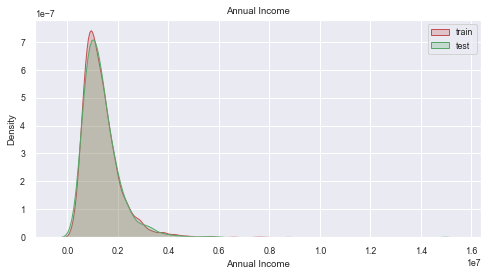

Tax Liens
MannwhitneyuResult(statistic=9336937.5, pvalue=0.09836860283803656)


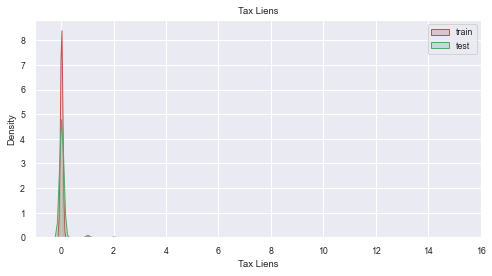

Number of Open Accounts
MannwhitneyuResult(statistic=9279311.5, pvalue=0.22142637178864455)


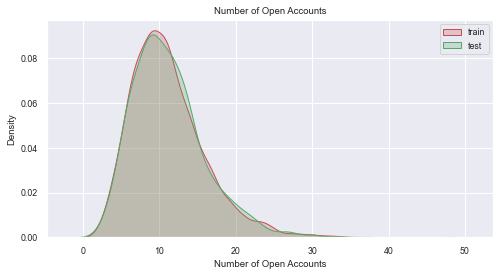

Years of Credit History
MannwhitneyuResult(statistic=9339658.0, pvalue=0.3886945952485082)


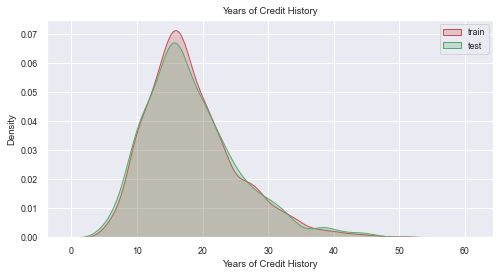

Maximum Open Credit
MannwhitneyuResult(statistic=9337869.0, pvalue=0.3832220993414893)


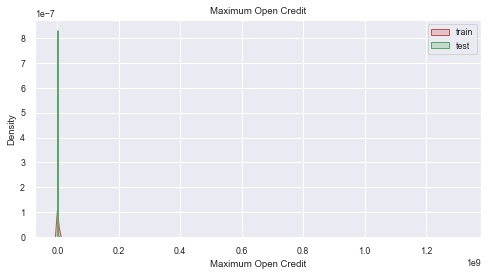

Number of Credit Problems
MannwhitneyuResult(statistic=9295513.5, pvalue=0.14195772552376257)


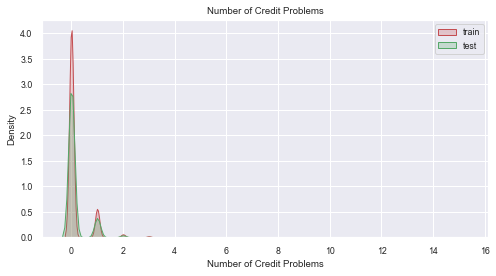

Months since last delinquent
MannwhitneyuResult(statistic=6974400.5, pvalue=1.712573746209761e-82)


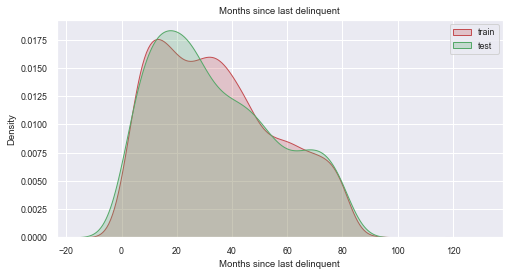

Bankruptcies
MannwhitneyuResult(statistic=9254231.0, pvalue=0.036681545859698156)


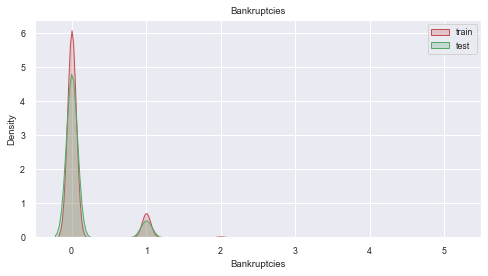

Current Loan Amount
MannwhitneyuResult(statistic=9230199.5, pvalue=0.12317435968682072)


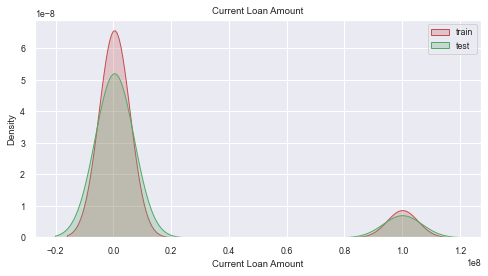

Current Credit Balance
MannwhitneyuResult(statistic=9334050.0, pvalue=0.3716147491364306)


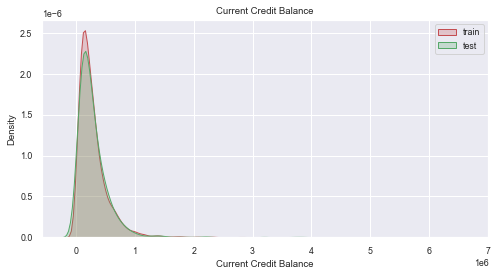

Monthly Debt
MannwhitneyuResult(statistic=9288187.0, pvalue=0.24369523330673137)


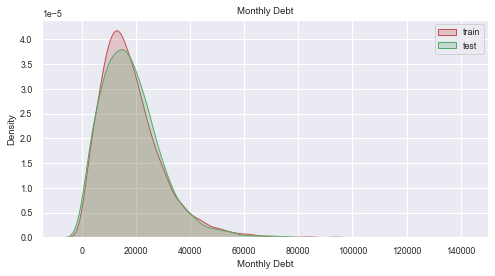

Credit Score
MannwhitneyuResult(statistic=9359581.5, pvalue=0.45091647518794764)


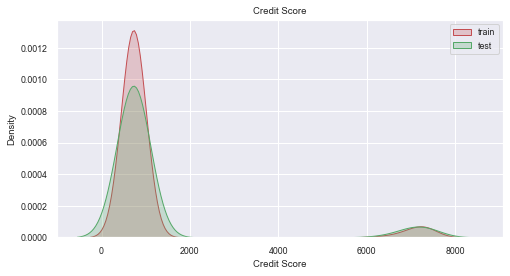

In [103]:
figsize = (8, 4)
for col in num_features:
    plt.figure(figsize=figsize)
    sns.set(font_scale=0.8)
    sns.kdeplot(df[col], shade=True, label='train', color='r')
    sns.kdeplot(test[col], shade=True, label='test', color='g')
    print(col)
    print(mannwhitneyu(df[col], test[col]))
    plt.legend()
    plt.title(col)
    plt.show()

### Строим гистограммы по категориальным признакам

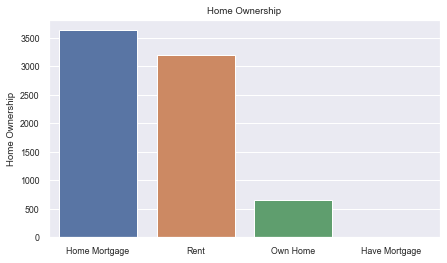

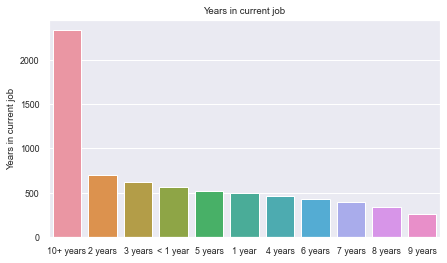

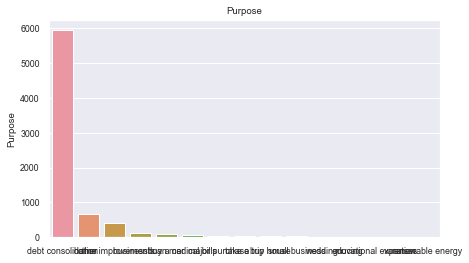

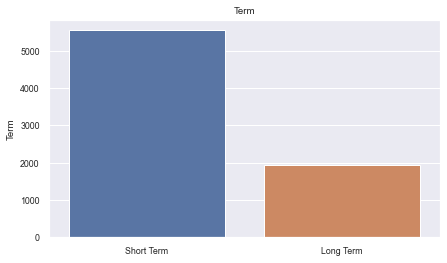

In [104]:
for col_name in cat_features:
    plt.figure(figsize=(7,4))
    sns.barplot(df[col_name].value_counts().index, df[col_name].value_counts()).set_title(col_name)
    plt.show()

### Видим дисбаланс целевой метки

In [105]:
df['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

### Строим корреляционную матрицу признаков

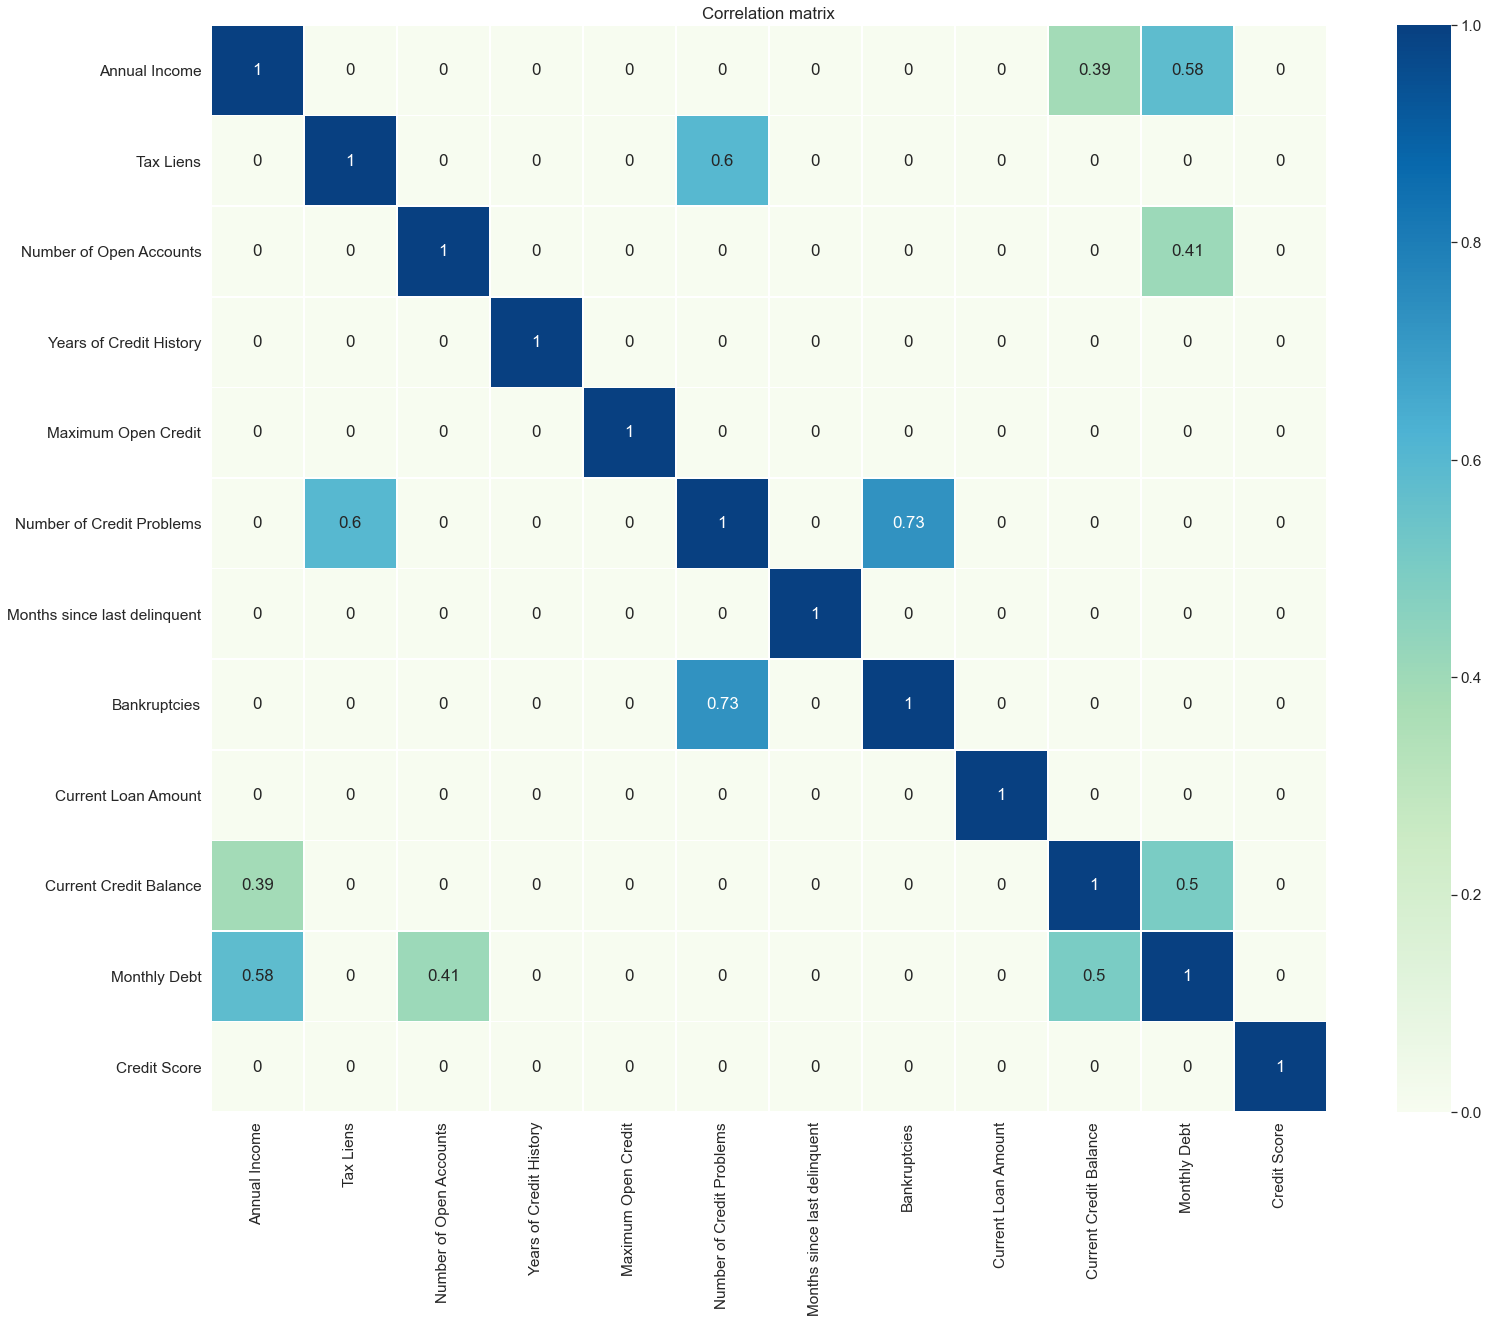

In [106]:
plt.figure(figsize = (25,20))

sns.set(font_scale=1.4)

corr_matrix = df[num_features].corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

### Смотрим, как численные признаки коррелируют с целевой меткой

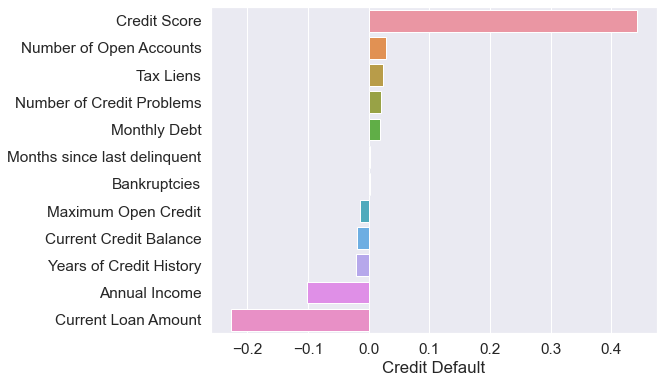

In [107]:
corr_with_target = df.corr().iloc[:-1, -1].sort_values(ascending=False)
plt.figure(figsize=(8,6))
sns.barplot(corr_with_target, corr_with_target.index)
plt.show()

# Обработка пропусков

### Посмотрим на пропущенные значения

In [108]:
df.isna().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

### Годовой доход, число месяцев с последней просрочки, банкротства и кредитный рейтинг заполним медианой

In [109]:
df['Annual Income'].median()

1168386.0

In [110]:
df['Annual Income'].fillna(df['Annual Income'].median(), inplace=True)
df['Months since last delinquent'].fillna(df['Months since last delinquent'].median(), inplace=True)
df['Bankruptcies'].fillna(df['Bankruptcies'].median(), inplace=True)
df['Credit Score'].fillna(df['Credit Score'].median(), inplace=True)

### Стаж на текущей работе заполним модой, потом надо заполнить на "менее года" и сравнить

In [111]:
df['Years in current job'].mode()

0    10+ years
dtype: object

In [112]:
df['Years in current job'].fillna(df['Years in current job'].mode()[0], inplace=True)

In [113]:
for cat_col_name in df.select_dtypes(include='object'):
    print(str(cat_col_name) + '\n\n' + str(df[cat_col_name].value_counts()) + '\n' + '_' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
____________________________________________________________________________________________________

Years in current job

10+ years    2703
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
____________________________________________________________________________________________________

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation  

In [114]:
num_features = df.select_dtypes(exclude='object').drop(columns='Credit Default').columns.to_list()
cat_features = df.select_dtypes(include='object').columns.to_list()

In [115]:
num_features

['Annual Income',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score']

In [116]:
cat_features

['Home Ownership', 'Years in current job', 'Purpose', 'Term']

### Масштабирование и разбиение на train & test

In [117]:
cat_features

['Home Ownership', 'Years in current job', 'Purpose', 'Term']

In [118]:
encoder = LabelEncoder()
for cat_feature in cat_features:
    df[cat_feature] = encoder.fit_transform(df[cat_feature])

In [119]:
df.Purpose

0       3
1       3
2       3
3       3
4       3
       ..
7495    9
7496    3
7497    1
7498    3
7499    3
Name: Purpose, Length: 7500, dtype: int64

In [120]:
scaler = StandardScaler()
df_norm = df.copy()
df_norm[num_features] = scaler.fit_transform(df_norm[num_features])
df = df_norm.copy()

In [121]:
num_features

['Annual Income',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score']

In [122]:
target_name = 'Credit Default'
X = df.drop(columns=target_name)
y = df[target_name]

In [123]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.33, stratify=y)

In [124]:
y_train

1454    0
1388    0
6135    1
4285    1
6300    1
       ..
165     0
5407    0
5879    0
3899    0
5888    1
Name: Credit Default, Length: 5025, dtype: int64

### Попробую заполнять пропуски моделями случайного леса

In [125]:
def fill_na(data, target_col, col_type='num', model=None):
    data = data.copy()
    cols_with_nan = data.isna().sum()[data.isna().sum() != 0].drop(target_col).index.to_list()
    
    features = data.columns
    data = data[features]
    
    if 'Credit Default' in data.columns:
        train = data[~data[target_col].isna()].drop(columns='Credit Default')
        predict_data = data[data[target_col].isna()].drop(columns='Credit Default')
    else:
        train = data[~data[target_col].isna()]
        predict_data = data[data[target_col].isna()]
    
#     train = data[~data[target_col].isna()]
#     predict_data = data[data[target_col].isna()]
    if model:
        cols_with_nan.append(target_col)
#         print(predict_data.drop(columns=cols_with_nan))
        pred = model.predict(predict_data.drop(columns=cols_with_nan))
        data.loc[data[target_col].isna(), target_col] = list(pred)
        return data

    X = train.drop(columns=target_col)
    y = train[target_col]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,
                                                        shuffle=True,
                                                        random_state=32)
    
    params = {'n_estimators': [50, 100],
              'max_depth': [5, 10],
              'min_samples_leaf': [10, 20]}
    if col_type=='num':
        gs = GridSearchCV(RandomForestRegressor(random_state=42), params, scoring='r2')
        gs.fit(X_train.drop(columns=cols_with_nan), y_train)
        model = gs.best_estimator_

        pred_train = model.predict(X_train.drop(columns=cols_with_nan))
        pred_test = model.predict(X_test.drop(columns=cols_with_nan))

        print(f"r2 на train: {r2_score(y_train, pred_train)}")
        print(f"r2 на test: {r2_score(y_test, pred_test)}")
    
    elif col_type=='cat':
        gs = GridSearchCV(RandomForestClassifier(random_state=42), params, scoring='r2')
        gs.fit(X_train.drop(columns=cols_with_nan), y_train)
        model = gs.best_estimator_
   
        pred_train = model.predict(X_train.drop(columns=cols_with_nan))
        pred_test = model.predict(X_test.drop(columns=cols_with_nan))

        print(f"f1 на train: {f1_score(y_train, pred_train, average='macro')}")
        print(f"f1 на test: {f1_score(y_test, pred_test, average='macro')}")
      
    return model

### Сделаю класс для удобной предобработки данных

In [126]:
class DataPreprocessing:
    def __init__(self):
        self.medians=None
        self.mode=None
        self.cat_features=None
        self.encoder = LabelEncoder()
        self.scaler = StandardScaler()
        self.target = None
        self.features = None
        self.credit_score_model = None
        self.annual_income_model = None
        self.month_model = None
        self.bankruptcies_model = None
        self.job_years_model = None
    def fit(self, X):
        for cat_feature in cat_features:
            X.loc[~X[cat_feature].isna(), cat_feature] = \
            self.encoder.fit_transform(X.loc[~X[cat_feature].isna(), cat_feature])
        self.medians = X.median()
        self.modes = X.mode()
        self.credit_score_model = fill_na(X, 'Credit Score')
        X = fill_na(X, 'Credit Score', model=self.credit_score_model)
        self.annual_income_model = fill_na(X, 'Annual Income')
        X = fill_na(X, 'Annual Income', model=self.annual_income_model)
        self.month_model = fill_na(X, 'Months since last delinquent')
        X = fill_na(X, 'Months since last delinquent', model=self.month_model)
        self.bankruptcies_model = fill_na(X, 'Bankruptcies')
        X = fill_na(X, 'Bankruptcies', model=self.bankruptcies_model)
        self.job_years_model = fill_na(X, 'Years in current job')
        X = fill_na(X, target_col='Years in current job', model=self.job_years_model)
    def transform(self, X, how = 'simple'):
        self.cat_features = X.select_dtypes(include='object').columns.to_list()
        self.num_features = X.select_dtypes(exclude='object').columns.to_list()
        if 'Credit Default' in self.num_features:
            self.num_features.remove('Credit Default')
        for cat_feature in cat_features:
            X.loc[~X[cat_feature].isna(), cat_feature] = \
            self.encoder.fit_transform(X.loc[~X[cat_feature].isna(), cat_feature])
        
        X = fill_na(X, 'Credit Score', model=self.credit_score_model)
        X = fill_na(X, 'Annual Income', model=self.annual_income_model)
        X = fill_na(X, 'Months since last delinquent', model=self.month_model)
        X = fill_na(X, 'Bankruptcies', model=self.bankruptcies_model)
        X = fill_na(X, target_col='Years in current job', model=self.job_years_model)

        if how=='simple':
            X[self.num_features] = self.scaler.fit_transform(X[self.num_features]) 
        if how=='trees':
            for cat_feature in self.cat_features:
                X[cat_feature] = self.encoder.fit_transform(X[cat_feature])
        if how=='cat':
            pass

        X['Years in current job'] = X['Years in current job'].astype('int')
        return X

In [127]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [128]:
test

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,Home Mortgage,1020053.0,10+ years,0.0,14.0,29.1,559152.0,1.0,68.0,1.0,debt consolidation,Short Term,99999999.0,162735.0,15046.0,745.0
2496,Home Mortgage,NaN,2 years,0.0,15.0,17.0,1737780.0,0.0,77.0,0.0,debt consolidation,Short Term,468512.0,1439269.0,32996.0,NaN
2497,Home Mortgage,1171806.0,2 years,0.0,48.0,12.8,1706430.0,0.0,NaN,0.0,debt consolidation,Short Term,430496.0,676438.0,36912.0,695.0
2498,Rent,723520.0,10+ years,0.0,14.0,28.8,945780.0,0.0,NaN,0.0,debt consolidation,Short Term,257774.0,391248.0,13506.0,744.0


In [129]:
# train['Credit Default'] = train['Credit Default'].astype='object'

In [130]:
preprocessing = DataPreprocessing()
preprocessing.fit(train)
train = preprocessing.transform(train)
test = preprocessing.transform(test)
train

r2 на train: 0.04425764377443819
r2 на test: 0.013531932431964155
r2 на train: 0.5885611836006767
r2 на test: 0.40190872256335586
r2 на train: 0.10369335936337176
r2 на test: 0.0388129342032405
r2 на train: 0.8274112460583929
r2 на test: 0.81964119171939
r2 на train: 0.060768529585026654
r2 на test: 0.025902650133816985


,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,0.063707,-1.126532,3,-0.110953,-0.026674,1.133645,-0.016174,1.664779,0.996263,2.545732,-0.351267,0.591517,2.760520,-0.762772,-0.872085,-0.290911,0
1,0.063707,-0.446477,1,-0.110953,0.788223,-0.428528,0.014763,-0.340979,-0.068592,-0.337099,-0.351267,-1.690569,-0.363620,0.330781,0.004909,-0.299305,1
2,-0.981812,-0.789477,8,-0.110953,-0.026674,2.369181,0.014807,-0.340979,-0.207415,-0.337099,-0.351267,0.591517,2.760520,0.058379,-0.391034,-0.295808,0
3,0.063707,-0.722327,6,-0.110953,-0.637847,0.593985,-0.049781,1.664779,0.572929,2.545732,-0.351267,0.591517,-0.368118,-0.610282,-0.584980,-0.329384,0
4,1.109226,-0.758375,8,-0.110953,0.380774,-0.669954,-0.034902,1.664779,0.667227,-0.337099,-0.351267,0.591517,-0.367978,-0.618292,-0.933631,-0.311896,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,1.109226,-1.226519,10,-0.110953,-1.656468,-1.394234,-0.052248,-0.340979,-0.103763,-0.337099,2.538494,0.591517,-0.367868,-0.680639,-1.376362,-0.327285,0
7496,-0.981812,0.189898,0,-0.110953,-0.230398,1.162048,-0.016152,-0.340979,0.542433,-0.337099,-0.351267,-1.690569,-0.358011,0.524039,-0.463816,4.368426,1
7497,1.109226,0.621566,6,-0.110953,0.177050,1.957336,0.052029,-0.340979,-0.337261,-0.337099,-1.314520,0.591517,2.760520,0.591407,-0.489306,-0.291611,0
7498,-0.981812,1.044542,2,-0.110953,2.010568,1.162048,0.012237,-0.340979,-0.105783,-0.337099,-0.351267,0.591517,-0.352647,0.585907,1.576689,-0.043926,0


In [39]:
test.isna().sum()

Home Ownership                  0
Annual Income                   0
Years in current job            0
Tax Liens                       0
Number of Open Accounts         0
Years of Credit History         0
Maximum Open Credit             0
Number of Credit Problems       0
Months since last delinquent    0
Bankruptcies                    0
Purpose                         0
Term                            0
Current Loan Amount             0
Current Credit Balance          0
Monthly Debt                    0
Credit Score                    0
dtype: int64

In [40]:
target_name = 'Credit Default'
X = train.drop(columns=target_name)
y = train[target_name]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, stratify=y)

In [41]:
X_train

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
6123,1.109226,-0.639175,3,-0.110953,0.584498,0.238946,-0.015603,-0.340979,1.346221,-0.337099,-0.351267,-1.690569,-0.362086,0.296947,-0.238593,-0.336379
6001,0.063707,-0.723754,9,-0.110953,-0.230398,-0.087690,-0.032637,-0.340979,-0.730230,-0.337099,-0.351267,0.591517,-0.370225,-0.907252,-0.204298,-0.301404
2381,-0.981812,0.356583,8,-0.110953,-0.434123,-0.826171,-0.043149,-0.340979,-0.142409,-0.337099,-0.351267,0.591517,-0.364889,-0.277685,-0.289155,-0.306300
1380,1.109226,-0.814895,3,-0.110953,3.232913,2.369181,0.006014,-0.340979,-1.667982,-0.337099,-0.351267,0.591517,-0.366337,-0.201530,-0.181910,-0.295808
7443,1.109226,-0.100624,3,-0.110953,-0.637847,-0.755164,-0.026742,-0.340979,-0.001781,-0.337099,-0.351267,0.591517,-0.365035,-0.228250,0.088089,-0.293010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1542,1.109226,-1.009876,3,-0.110953,-0.230398,-0.073488,-0.046791,-0.340979,0.011894,-0.337099,-0.351267,0.591517,-0.367104,-0.721885,-0.305590,-0.359462
3899,-0.981812,1.911483,10,-0.110953,0.788223,-0.059287,0.030982,-0.340979,-0.596266,-0.337099,-0.351267,0.591517,2.760520,0.592303,3.526803,-0.291611
1791,1.109226,2.577069,10,-0.110953,0.584498,1.289862,0.163670,-0.340979,-0.128379,-0.337099,-0.351267,-1.690569,-0.351292,6.737217,2.558999,0.049702
3757,-0.981812,0.196889,6,-0.110953,2.010568,-0.939784,-0.016581,-0.340979,-0.073134,-0.337099,-0.351267,0.591517,-0.365223,0.077687,0.217806,4.354436


In [42]:
y_train

6123    0
6001    1
2381    1
1380    0
7443    0
       ..
1542    1
3899    0
1791    1
3757    1
885     1
Name: Credit Default, Length: 6000, dtype: int64

### Построение и оценка базовых моделей

#### k neighbors

In [43]:
model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)
evaluate_preds(model_knn, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.82      0.95      0.88      4310
           1       0.77      0.47      0.58      1690

    accuracy                           0.81      6000
   macro avg       0.80      0.71      0.73      6000
weighted avg       0.81      0.81      0.79      6000

TEST

              precision    recall  f1-score   support

           0       0.78      0.88      0.83      1077
           1       0.54      0.36      0.43       423

    accuracy                           0.73      1500
   macro avg       0.66      0.62      0.63      1500
weighted avg       0.71      0.73      0.72      1500

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               949  128
1               270  153


#### Support Vector Classifier - без гиперпараметров плохо классифицирует 1 класс, f1 для первого класса всего 0.36, средний f1 score = 0.62 на тесте, зато нет переобучения, на тесте метрики даже чуть лучше. Веса классов далее хорошо себя показывают и значительно повышают метрики - f1 для первого класса = 53, средний f1 = 0,65

In [44]:
model_svc = LinearSVC(random_state=42)
model_svc.fit(X_train, y_train)
evaluate_preds(model_svc, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.77      0.99      0.86      4310
           1       0.88      0.24      0.38      1690

    accuracy                           0.78      6000
   macro avg       0.82      0.62      0.62      6000
weighted avg       0.80      0.78      0.73      6000

TEST

              precision    recall  f1-score   support

           0       0.77      0.98      0.86      1077
           1       0.84      0.24      0.38       423

    accuracy                           0.77      1500
   macro avg       0.80      0.61      0.62      1500
weighted avg       0.79      0.77      0.72      1500

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1057   20
1                320  103


#### LightGBM - сильное переобучение, f1 для 1 класса на трейне 0.82, а на тесте 0.48, средний f1 также сильно падает на тесте: 0.88 и 0.67

In [45]:
X_train.dtypes

Home Ownership                  float64
Annual Income                   float64
Years in current job              int64
Tax Liens                       float64
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems       float64
Months since last delinquent    float64
Bankruptcies                    float64
Purpose                         float64
Term                            float64
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
dtype: object

In [46]:
X_train['Years in current job'] = X_train['Years in current job'].astype('int')
X_test['Years in current job'] = X_test['Years in current job'].astype('int')

In [47]:
model_lgb = LGBMClassifier(random_state=42)
model_lgb.fit(X_train, y_train)
evaluate_preds(model_lgb, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.88      1.00      0.94      4310
           1       0.99      0.66      0.79      1690

    accuracy                           0.90      6000
   macro avg       0.93      0.83      0.86      6000
weighted avg       0.91      0.90      0.89      6000

TEST

              precision    recall  f1-score   support

           0       0.78      0.94      0.86      1077
           1       0.69      0.34      0.46       423

    accuracy                           0.77      1500
   macro avg       0.74      0.64      0.66      1500
weighted avg       0.76      0.77      0.74      1500

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1013   64
1                279  144


### Попробую подобрать оптимальные гиперпараметры для LGBM и XGBM

#### XGMB: {'max_depth': 5, 'n_estimators': 200}
0.4607590018227536 

Очень сильное переобучение

In [48]:
params = {'n_estimators': [200, 300], 'max_depth': [2,3,5]}

In [49]:
gs = GridSearchCV(XGBClassifier(), params, scoring='f1')
gs.fit(X_train, y_train)

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, validate_parameter

In [50]:
gs.best_params_

{'max_depth': 2, 'n_estimators': 300}

In [51]:
gs.best_score_

0.4676556681806214

In [52]:
model_xgb = gs.best_estimator_
evaluate_preds(model_xgb, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.83      0.98      0.90      4310
           1       0.91      0.50      0.65      1690

    accuracy                           0.85      6000
   macro avg       0.87      0.74      0.78      6000
weighted avg       0.86      0.85      0.83      6000

TEST

              precision    recall  f1-score   support

           0       0.78      0.93      0.85      1077
           1       0.65      0.34      0.45       423

    accuracy                           0.76      1500
   macro avg       0.72      0.63      0.65      1500
weighted avg       0.74      0.76      0.74      1500

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               999   78
1               279  144


### LGBM {'max_depth': 2, 'n_estimators': 100, 'num_leaves': 20}

0.5445270259112004

Получилось круто, переобучения практически нет, f1 для 1 класса 0.59 и 0.57, средний f1 0.7 и 0.68

In [53]:
params = {'n_estimators': [50,100,200], 'max_depth': [1,2,3], 'num_leaves': [10, 20]}

In [54]:
gs = GridSearchCV(LGBMClassifier(class_weight={0:1, 1:2.5}), params, scoring='f1')
gs.fit(X_train, y_train)

GridSearchCV(estimator=LGBMClassifier(class_weight={0: 1, 1: 2.5}),
             param_grid={'max_depth': [1, 2, 3], 'n_estimators': [50, 100, 200],
                         'num_leaves': [10, 20]},
             scoring='f1')

In [55]:
gs.best_params_

{'max_depth': 2, 'n_estimators': 200, 'num_leaves': 10}

In [56]:
gs.best_score_

0.5459842086213902

In [57]:
new_model_lgb = gs.best_estimator_
evaluate_preds(new_model_lgb, X_train, X_test, y_train,  y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.87      0.78      0.82      4310
           1       0.55      0.71      0.62      1690

    accuracy                           0.76      6000
   macro avg       0.71      0.74      0.72      6000
weighted avg       0.78      0.76      0.76      6000

TEST

              precision    recall  f1-score   support

           0       0.84      0.73      0.78      1077
           1       0.48      0.64      0.55       423

    accuracy                           0.70      1500
   macro avg       0.66      0.68      0.66      1500
weighted avg       0.74      0.70      0.71      1500

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               784  293
1               153  270


### Переходим к CatBoost

In [58]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
preprocessing = DataPreprocessing()
preprocessing.fit(train)
train = preprocessing.transform(train, how='cat')
test = preprocessing.transform(test, how='cat')

r2 на train: 0.04425764377443819
r2 на test: 0.013531932431964155
r2 на train: 0.5885611836006767
r2 на test: 0.40190872256335586
r2 на train: 0.10369335936337176
r2 на test: 0.0388129342032405
r2 на train: 0.8274112460583929
r2 на test: 0.81964119171939
r2 на train: 0.060768529585026654
r2 на test: 0.025902650133816985


In [59]:
y_train.value_counts()

0    4310
1    1690
Name: Credit Default, dtype: int64

In [60]:
disbalance = y_train.value_counts()[0]/y_train.value_counts()[1]
disbalance

2.5502958579881656

In [61]:
cat_features

['Home Ownership', 'Years in current job', 'Purpose', 'Term']

In [62]:
X = train.drop(columns=target_name)
y = train[target_name]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, stratify=y)

In [63]:
model_catb = CatBoostClassifier(random_state=42, 
                                class_weights=[1, disbalance], 
                                silent=True, 
                                eval_metric='F1',
                                use_best_model=True,
                                cat_features=cat_features)
model_catb.fit(X_train, y_train, plot=True, eval_set=(X_test, y_test))
evaluate_preds(model_catb, X_train, X_test, y_train, y_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TRAIN

              precision    recall  f1-score   support

           0       0.86      0.78      0.82      4310
           1       0.55      0.68      0.61      1690

    accuracy                           0.75      6000
   macro avg       0.71      0.73      0.71      6000
weighted avg       0.77      0.75      0.76      6000

TEST

              precision    recall  f1-score   support

           0       0.84      0.74      0.79      1077
           1       0.49      0.63      0.55       423

    accuracy                           0.71      1500
   macro avg       0.66      0.69      0.67      1500
weighted avg       0.74      0.71      0.72      1500

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               802  275
1               156  267


In [65]:
evaluate_preds(model_catb, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.86      0.78      0.82      4310
           1       0.55      0.68      0.61      1690

    accuracy                           0.75      6000
   macro avg       0.71      0.73      0.71      6000
weighted avg       0.77      0.75      0.76      6000

TEST

              precision    recall  f1-score   support

           0       0.84      0.74      0.79      1077
           1       0.49      0.63      0.55       423

    accuracy                           0.71      1500
   macro avg       0.66      0.69      0.67      1500
weighted avg       0.74      0.71      0.72      1500

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               802  275
1               156  267


In [67]:
feature_importances = pd.DataFrame(zip(X_train.columns, model_catb.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
12,Current Loan Amount,47.267034
15,Credit Score,22.786454
11,Term,6.011786
1,Annual Income,5.165108
0,Home Ownership,3.160592
6,Maximum Open Credit,2.484181
14,Monthly Debt,2.330081
2,Years in current job,2.221192
10,Purpose,1.942315
13,Current Credit Balance,1.909453


In [68]:
init_params = {'random_state':42, 
#                 'class_weights':[1, disbalance], 
                'silent':True, 
                'eval_metric':'F1',
                'cat_features':cat_features}

model_catb = CatBoostClassifier(**init_params)

In [69]:
params = {'iterations':[50, 200, 300, 500],
          'max_depth':[3, 5, 7, 10]}

In [70]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

In [71]:
grid_search = model_catb.grid_search(params, X_train, y_train, cv=cv, stratified=True, plot=True, refit=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.3429951691
bestIteration = 35

0:	loss: 0.3429952	best: 0.3429952 (0)	total: 200ms	remaining: 3s

bestTest = 0.3610451306
bestIteration = 176

1:	loss: 0.3610451	best: 0.3610451 (1)	total: 945ms	remaining: 6.61s

bestTest = 0.3840749415
bestIteration = 287

2:	loss: 0.3840749	best: 0.3840749 (2)	total: 2.08s	remaining: 9.02s

bestTest = 0.4126984127
bestIteration = 405

3:	loss: 0.4126984	best: 0.4126984 (3)	total: 3.76s	remaining: 11.3s

bestTest = 0.3268292683
bestIteration = 32

4:	loss: 0.3268293	best: 0.4126984 (3)	total: 3.98s	remaining: 8.76s

bestTest = 0.3640661939
bestIteration = 191

5:	loss: 0.3640662	best: 0.4126984 (3)	total: 5.16s	remaining: 8.61s

bestTest = 0.410022779
bestIteration = 298

6:	loss: 0.4100228	best: 0.4126984 (3)	total: 7.13s	remaining: 9.17s

bestTest = 0.4415011038
bestIteration = 464

7:	loss: 0.4415011	best: 0.4415011 (7)	total: 10.4s	remaining: 10.4s

bestTest = 0.3492822967
bestIteration = 45

8:	loss: 0.3492823	best: 0.4415011 (7)	to

In [72]:
grid_search

{'params': {'depth': 5, 'iterations': 500},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
               47,
       

#### Лучшие параметры: {'depth': 3, 'iterations': 50}

In [73]:
final_catb = CatBoostClassifier(**init_params, depth=3, iterations=500)
final_catb.fit(X_train, y_train)
evaluate_preds(final_catb, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.79      0.98      0.88      4310
           1       0.86      0.35      0.50      1690

    accuracy                           0.80      6000
   macro avg       0.83      0.67      0.69      6000
weighted avg       0.81      0.80      0.77      6000

TEST

              precision    recall  f1-score   support

           0       0.78      0.96      0.86      1077
           1       0.74      0.32      0.45       423

    accuracy                           0.78      1500
   macro avg       0.76      0.64      0.65      1500
weighted avg       0.77      0.78      0.74      1500

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1029   48
1                288  135


In [74]:
y_pred_proba = final_catb.predict_proba(X_test)

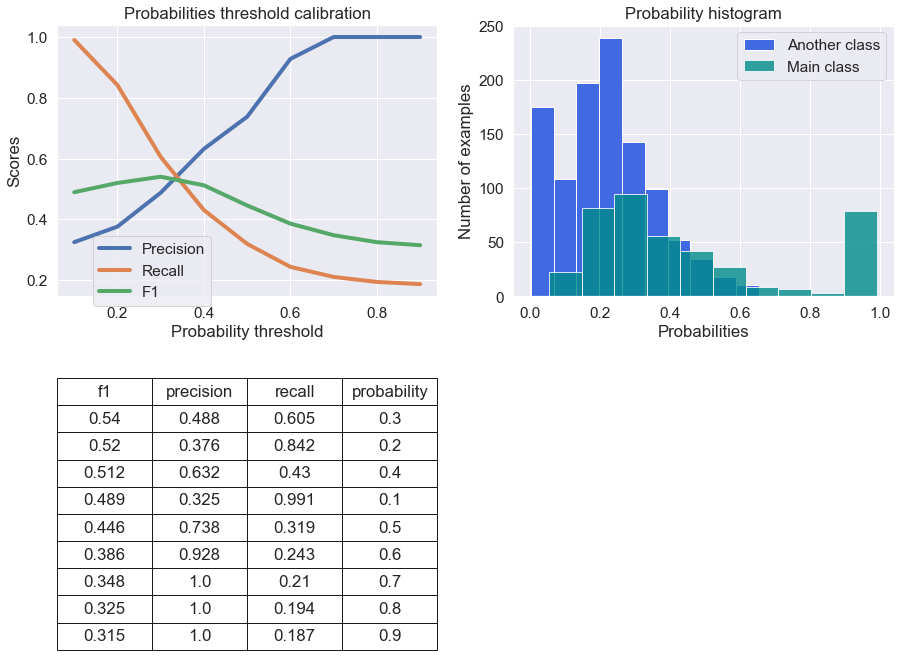

In [75]:
show_proba_calibration_plots(y_pred_proba[:, 1], y_test)

In [76]:
pd.DataFrame(y_pred_proba).describe()

,0,1
count,1500.000000,1500.000000
mean,0.714299,0.285701
std,0.219047,0.219047
min,0.008837,0.002902
25%,0.643783,0.153981
50%,0.759898,0.240102
75%,0.846019,0.356217
max,0.997098,0.991163


In [77]:
test['Years in current job'] = test['Years in current job'].astype('int')

In [78]:
prediction = model_catb.predict(test)

In [79]:
feature_importances = pd.DataFrame(zip(X_train.columns, final_catb.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
12,Current Loan Amount,41.246750
15,Credit Score,35.443501
1,Annual Income,5.379236
11,Term,3.923857
6,Maximum Open Credit,2.921320
14,Monthly Debt,2.786005
8,Months since last delinquent,1.579341
13,Current Credit Balance,1.459678
5,Years of Credit History,1.343367
4,Number of Open Accounts,1.151495


In [80]:
# submission = pd.read_csv('sample_submission.csv')
# submission['Credit Default'] = prediction
# submission.to_csv('2nd submission', index=False)

In [81]:
pd.DataFrame(prediction).value_counts()

0    2179
1     321
dtype: int64

In [82]:
train

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,2,4.820870e+05,3,0.0,11.0,26.3,685960.0,1.0,49.775366,1.0,3,1,99999999.0,47386.0,7914.0,749.000000,0
1,2,1.025487e+06,1,0.0,15.0,15.3,1181730.0,0.0,33.877811,0.0,3,0,264968.0,394972.0,18373.0,737.000000,1
2,1,7.514120e+05,8,0.0,11.0,35.0,1182434.0,0.0,31.805272,0.0,3,1,99999999.0,308389.0,13651.0,742.000000,0
3,2,8.050680e+05,6,0.0,8.0,22.5,147400.0,1.0,43.455276,1.0,3,1,121396.0,95855.0,11338.0,694.000000,0
4,3,7.762640e+05,8,0.0,13.0,13.6,385836.0,1.0,44.863083,0.0,3,1,125840.0,93309.0,7180.0,719.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,3,4.021920e+05,10,0.0,3.0,8.5,107866.0,0.0,33.352727,0.0,9,1,129360.0,73492.0,1900.0,697.000000,0
7496,1,1.533984e+06,0,0.0,10.0,26.5,686312.0,0.0,43.000000,0.0,3,0,444048.0,456399.0,12783.0,7410.000000,1
7497,3,1.878910e+06,6,0.0,12.0,32.1,1778920.0,0.0,29.866768,0.0,1,1,99999999.0,477812.0,12479.0,748.000000,0
7498,1,2.216890e+06,2,0.0,21.0,26.5,1141250.0,0.0,33.322578,0.0,3,1,615274.0,476064.0,37118.0,1102.090651,0


In [83]:
smote_train = balance_df_by_target(train, 'Credit Default', method='smote')
smote_train['Years in current job'] = smote_train['Years in current job'].astype('int')
X_smote = smote_train.drop(columns='Credit Default')
y_smote = smote_train['Credit Default']
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, random_state=42, test_size=0.2)
smote_train.dtypes

Home Ownership                    int64
Annual Income                   float64
Years in current job              int64
Tax Liens                       float64
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems       float64
Months since last delinquent    float64
Bankruptcies                    float64
Purpose                           int64
Term                              int64
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
Credit Default                    int64
dtype: object

In [84]:
smote_model_catb = CatBoostClassifier(random_state=42, 
                                silent=True, 
                                eval_metric='F1',
                                use_best_model=True,
                                cat_features=cat_features)
smote_model_catb.fit(X_train, y_train, eval_set=(X_test, y_test))
evaluate_preds(smote_model_catb, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.87      0.97      0.92      4319
           1       0.96      0.86      0.91      4300

    accuracy                           0.91      8619
   macro avg       0.92      0.91      0.91      8619
weighted avg       0.92      0.91      0.91      8619

TEST

              precision    recall  f1-score   support

           0       0.80      0.91      0.85      1068
           1       0.90      0.77      0.83      1087

    accuracy                           0.84      2155
   macro avg       0.85      0.84      0.84      2155
weighted avg       0.85      0.84      0.84      2155

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               971   97
1               250  837


In [85]:
# test['Years in current job'] = test['Years in current job'].astype('int')
prediction = smote_model_catb.predict(test)

In [86]:
# submission = pd.read_csv('sample_submission.csv')
# submission['Credit Default'] = prediction
# submission.to_csv('smote_catb_submission', index=False)

In [87]:
sub = pd.read_csv('smote_catb_submission.csv')
sub

,Id,Credit Default
0,0,0
1,1,1
2,2,1
3,3,0
4,4,0
...,...,...
2495,2495,0
2496,2496,1
2497,2497,0
2498,2498,0


In [88]:
tomek_train = balance_df_by_target(train, 'Credit Default', method='tomek')
tomek_train['Years in current job'] = tomek_train['Years in current job'].astype('int')
X_tomek = tomek_train.drop(columns='Credit Default')
y_tomek = tomek_train['Credit Default']
X_train, X_test, y_train, y_test = train_test_split(X_tomek, y_tomek, random_state=42, test_size=0.2)
tomek_train.dtypes

Home Ownership                    int64
Annual Income                   float64
Years in current job              int64
Tax Liens                       float64
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems       float64
Months since last delinquent    float64
Bankruptcies                    float64
Purpose                           int64
Term                              int64
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
Credit Default                    int64
dtype: object

In [89]:
tomek_model_catb = CatBoostClassifier(random_state=42, 
                                silent=True, 
                                eval_metric='F1',
                                use_best_model=True,
                                cat_features=cat_features)
tomek_model_catb.fit(X_train, y_train, eval_set=(X_test, y_test))
evaluate_preds(tomek_model_catb, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.88      0.99      0.93      3719
           1       0.96      0.71      0.82      1681

    accuracy                           0.90      5400
   macro avg       0.92      0.85      0.88      5400
weighted avg       0.91      0.90      0.90      5400

TEST

              precision    recall  f1-score   support

           0       0.77      0.91      0.83       918
           1       0.69      0.42      0.52       432

    accuracy                           0.75      1350
   macro avg       0.73      0.67      0.68      1350
weighted avg       0.74      0.75      0.73      1350

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               834   84
1               249  183


In [90]:
tomek_model_catb2 = CatBoostClassifier(random_state=42)
grid_search = tomek_model_catb2.grid_search(params, X_train, y_train, cv=cv, stratified=True, plot=True, refit=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.5089914607
bestIteration = 49

0:	loss: 0.5089915	best: 0.5089915 (0)	total: 162ms	remaining: 2.43s

bestTest = 0.4783729507
bestIteration = 198

1:	loss: 0.4783730	best: 0.4783730 (1)	total: 610ms	remaining: 4.27s

bestTest = 0.4735080153
bestIteration = 298

2:	loss: 0.4735080	best: 0.4735080 (2)	total: 1.28s	remaining: 5.53s

bestTest = 0.4689405261
bestIteration = 486

3:	loss: 0.4689405	best: 0.4689405 (3)	total: 2.41s	remaining: 7.23s

bestTest = 0.5028824736
bestIteration = 49

4:	loss: 0.5028825	best: 0.4689405 (3)	total: 2.54s	remaining: 5.59s

bestTest = 0.4755389094
bestIteration = 197

5:	loss: 0.4755389	best: 0.4689405 (3)	total: 3.1s	remaining: 5.17s

bestTest = 0.4716280078
bestIteration = 297

6:	loss: 0.4716280	best: 0.4689405 (3)	total: 3.91s	remaining: 5.03s

bestTest = 0.4686766769
bestIteration = 440

7:	loss: 0.4686767	best: 0.4686767 (7)	total: 5.28s	remaining: 5.28s

bestTest = 0.5009489163
bestIteration = 49

8:	loss: 0.5009489	best: 0.4686767 (7)

In [91]:
grid_search

{'params': {'depth': 5, 'iterations': 500},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
               47,
       

In [92]:
tomek_model_catb2 = CatBoostClassifier(**init_params, depth=5, iterations=500)
tomek_model_catb2.fit(X_train, y_train)
evaluate_preds(tomek_model_catb2, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.82      0.98      0.89      3719
           1       0.91      0.52      0.66      1681

    accuracy                           0.83      5400
   macro avg       0.86      0.75      0.77      5400
weighted avg       0.85      0.83      0.82      5400

TEST

              precision    recall  f1-score   support

           0       0.76      0.93      0.84       918
           1       0.71      0.38      0.50       432

    accuracy                           0.75      1350
   macro avg       0.74      0.66      0.67      1350
weighted avg       0.74      0.75      0.73      1350

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               850   68
1               266  166
